# Finding Similar Songs - Part 2: Siamese Networks

In the first part of this tutorial I have introduced the traditional distance based approach to similarity estimations. The main idea is that features are extracted from the audio content. These features are numeric descriptions of semantically relevant information. An example for a high-level feature is the number of beats per minute which is a description for the tempo of a song. Music feature-sets are more abstract and describe the spectral or rhythmical distribution of energy. These are not single but vectors of numbers. Thus, a song is semantically described by this vector and if the set of extracted features spans over various music characteristics such as rhythm, timbre, harmonics, complexity, etc. then calculating the similarity of the vector's numbers is considered to be an approximation of music similarity. Thus, the lower the numerical distance between two vectors, the higher their acoustic similarity. For this reason these approaches are known as *Distance based* methods. They mainly depend on the selected sets of features and on the similarity metric chosen to compare their values.

In the second part of this tutorial we are now focussing on an approach, where the feature representation, as well as the similarity function is learned from the underlying dataset.


## Tutorial Overview

1. Loading data
2. Preprocess data
3. Define Model
4. Fit Model
5. Evaluate Model



## Requiremnts

The requirements are the same as for the first part of the tutorials. Please follow the instructions of part one if you have trouble running this tutorial.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

In [2]:
# visualization
%matplotlib inline

# numeric and scientific processing
import numpy as np
import pandas as pd

# misc
import os
import progressbar

from IPython.display import IFrame
from IPython.display import HTML, display

pd.set_option('display.max_colwidth', -1)

# Loading Data

We will use the same data that we downloaded from Spotify in Part 1 of the Tutorial. Because we used the joblib library, we will not have to wait that long, because the data is already cached on our harddrive.

In [3]:
DATASET_PATH    = "D:/Research/Data/MIR/MagnaTagATune/ISMIR2018"

AUTIO_ROOT_PATH = "%s/mp3_full" % DATASET_PATH

## Load Feature Data

load feature data from numpy pickle

In [4]:
with np.load("%s/ISMIR2018_tut_Magnagtagatune_spectrograms.npz" % DATASET_PATH) as npz:
    melspecs      = npz["features"]
    clip_id       = npz["clip_id"]
    
melspecs.shape

(6380, 80, 80)

prepare feature-metadata for alignment with dataset meta-data

In [5]:
feature_metadata = pd.DataFrame({"featurespace_id": np.arange(melspecs.shape[0]), 
                                 "clip_id"        : clip_id})

## Load Metadata

load meta-data from csv-file.

In [6]:
metadata = pd.read_csv("./metadata/ismir2018_tut_part_2_genre_metadata.csv", index_col=0)
metadata.shape

(2617, 10)

Align featuredata with metadata

In [7]:
metadata = metadata.reset_index()
metadata = metadata.merge(feature_metadata, left_on="clip_id", right_on="clip_id", how="inner", left_index=True, right_index=False)
metadata = metadata.set_index("index")

Add HTML5 audio player component for listening to similarity retrieval results

In [8]:
tmp                = metadata.mp3_path.str.split("/", expand=True)
metadata["player"] = '<audio src="http://localhost:9999/' + tmp[6] + '/' + tmp[7] +'" controls>'

## Load Labels

Load labels from csv-file

In [9]:
labels = pd.read_csv("./metadata/ismir2018_tut_part_2_genre_labels.csv", index_col=0)

labels.shape

(2617, 7)

## Align Meta-data and Feature-data

Sort Metadata by Feature-space ID => metadata is aligned to feature-data

In [10]:
metadata.sort_values("featurespace_id", inplace=True)

# subsample feature-space
melspecs = melspecs[metadata.featurespace_id].astype(np.float32)

# re-enumerate sub-sampled feature-space (alignment)
metadata["featurespace_id"] = np.arange(metadata.shape[0])

# align labels
labels = labels.loc[metadata.index]

Add the layer-dimension to the feature-space (required by the convolutional neural networks. Only one layer added => mono-channel audio)

In [11]:
melspecs = np.expand_dims(melspecs, 3)

# Siamese Networks

A Siamese neural network is a neural network architecture where two inputs are fed into the same stack of network layers. This is where the name comes from. The shared layers are "similar" to Siamese Twins. By feeding two inputs to the shared layers, two representations are generated which can be used for comparison. To train the network according a certain task, it requires labelled data. To learn a simlarity function, these labels should indicate if the two input are similar or dissimilar.

This is exactly the approach initially described by Hadsell-et-al.'06 (http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf). The authors create pairs of simlar and dissimilar images. These are fed into a Siamese NEtwork stack. Finally, the model calculates the eucledian distance between the two generated representations. A contrastive loss is used, to optimize the learned simlarity.

To calculate the similarity between a seed image and the rest of the collection, the model is applied to predict the distance between this seed image and every other. The result is a list of distances which has to be sorted descendingly.

The following code example follows this approach:

**Keras**

We use the high-level deep learning API Keras: https://keras.io/

In [12]:
from keras.models       import Model
from keras.layers       import Input, Lambda, Dense, Conv2D, Flatten, MaxPooling2D, Concatenate
from keras.layers       import Dropout, BatchNormalization, GaussianNoise
from keras.optimizers   import Nadam, SGD, Adam, RMSprop
from keras.constraints  import unit_norm
from keras.regularizers import l2
from keras import backend as K

Using TensorFlow backend.


First we define a distance measure to compare the two representations. We will be using the well known Eucledian distance:

In [13]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

### The Siamese Network Architecture

Now we define the Siamese Network Architecture. It consists of two fully connected layers. These layers are shared among the "Siamese twins". The network takes two inputs. One goes to the left twin, the other to the right one. The Eucledian distance of the output of each twin is calculated which is the final output of the model.

In [14]:
def create_siamese_network():

    # --- input layers
    input_ref = Input((80,80,1), name="input_ref") # reference track
    input_dif = Input((80,80,1), name="input_dif") # different track
    
    # --- input pre-processing
    gn = GaussianNoise(0.2, name="gauss_noise")    # add noise to input during training to avoid overfitting
    bn = BatchNormalization(name="bnorm_input")    # normalize input

    # --- CNN-Stack A
    cnn_a_1 = Conv2D(16, (21,11), 
                     padding            = "same", 
                     activation         = "relu", 
                     kernel_regularizer = l2(0.0001), 
                     name               = "conv_a")
    
    cnn_a_2 = MaxPooling2D((20,4), name = "max_pooling_a")
    cnn_a_3 = BatchNormalization(  name = "bnorm_a")
    cnn_a_4 = Flatten(             name = "flatten_a")

    # --- CNN-Stack B
    cnn_b_1 = Conv2D(16, (11,21), 
                     padding            = "same", 
                     activation         = "relu", 
                     kernel_regularizer = l2(0.0001), 
                     name               = "conv_b")
    
    cnn_b_2 = MaxPooling2D((4,20), name = "max_pooling_b")
    cnn_b_3 = BatchNormalization(  name = "bnorm_b")
    cnn_b_4 = Flatten(             name = "flatten_b")

    # --- merge parallel CNN Stacks
    mrg = Concatenate(axis=1, name="concatenate")

    # --- Fully connected layer => learned representation layer
    hidden_layer = Dense(256, activation="elu", kernel_constraint=unit_norm())
    
    # --- function to assemble shared layers
    def get_shared_dnn(m_input):
        shared_cnn_a = cnn_a_4(cnn_a_3(cnn_a_2(cnn_a_1(bn(gn(m_input))))))
        shared_cnn_b = cnn_b_4(cnn_b_3(cnn_b_2(cnn_b_1(bn(gn(m_input))))))

        return hidden_layer(mrg([shared_cnn_a,shared_cnn_b]))

    # --- instantiate  shared layers
    siamese_ref = get_shared_dnn(input_ref)
    siamese_dif = get_shared_dnn(input_dif)

    # --- calculate dissimilarity
    dist  = Lambda(euclidean_distance, output_shape=lambda x: x[0])([siamese_ref, siamese_dif])
    
    # --- build model
    model = Model(inputs=[input_ref, input_dif], outputs=dist)
    
    return model

model = create_siamese_network()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ref (InputLayer)          (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
input_dif (InputLayer)          (None, 80, 80, 1)    0                                            
__________________________________________________________________________________________________
gauss_noise (GaussianNoise)     (None, 80, 80, 1)    0           input_ref[0][0]                  
                                                                 input_ref[0][0]                  
                                                                 input_dif[0][0]                  
                                                                 input_dif[0][0]                  
__________

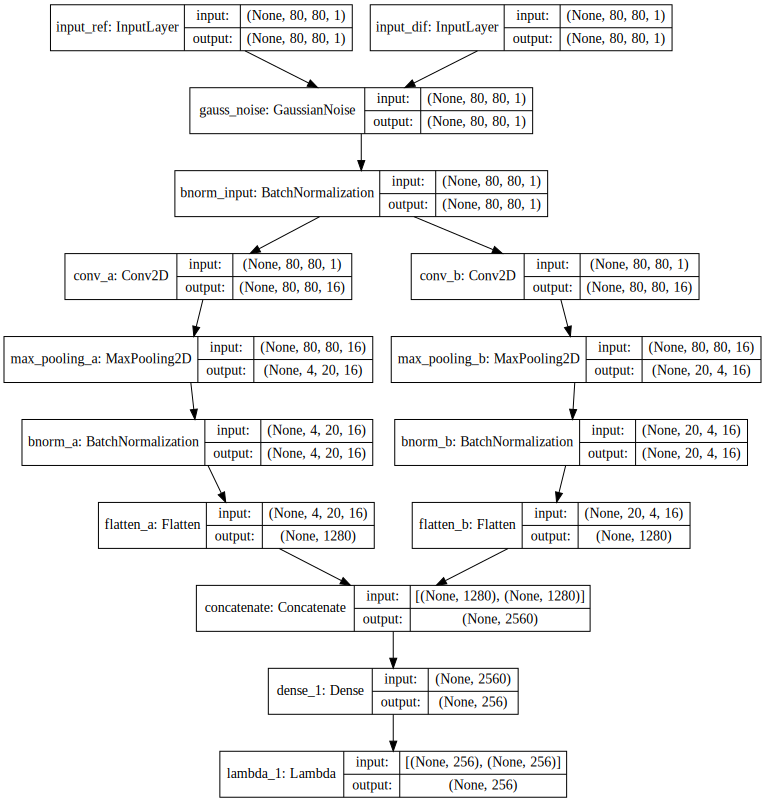

In [15]:
from IPython.display       import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, 
                 show_shapes      = True, 
                 show_layer_names = True).create(prog='dot', format='svg'))

**Contrastive Loss**

The contrastive loss is based on the Euclidean distance and measures the cost of data pairs. The objective of the contrastive loss is to minimize the distance between a similar pair and to separate any two dissimilar data with a distance margin

In [16]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

### Create Data-Pairs

Now we have to prepare and partition the input data. Because it is a pair-wise comparison approach, we have to create pairs of input instances with sequentially one row containing the reference track and a similar example and the consecutive row containing the reference track and a dissimilar example.

In [17]:
def create_pairs(feature_data, metadata, labels, num_triplets_per_track):
    
    data_ref  = []
    data_dif  = []
    gt_labels = []
    
    pbar = progressbar.ProgressBar(max_value=metadata.shape[0])
        
    for row_id, q_track in pbar(metadata.iterrows()):
        
        for _ in range(num_triplets_per_track):
            
            label_differences = np.abs(labels - labels.loc[row_id]).sum(axis=1)
            
            similar_instances    = label_differences[label_differences == 0]
            dissimilar_instances = label_differences[label_differences != 0] 
            
            # search similar and dissimilar examples
            pos_example_idx      = similar_instances.sample(1).index.values[0]
            neg_example_idx      = dissimilar_instances.sample(1).index.values[0]
            
            # create feature triplets
            feat_id_ref          = metadata.loc[row_id].featurespace_id
            feat_id_pos          = metadata.loc[pos_example_idx].featurespace_id
            feat_id_neg          = metadata.loc[neg_example_idx].featurespace_id
            
            # genuine pair
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_pos])
            gt_labels.append(1)
            
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_neg])
            gt_labels.append(0)

    return [np.asarray(data_ref), np.asarray(data_dif)], np.asarray(gt_labels)

Exectue the function to prepare the input data

In [18]:
# create pairs
data_pairs, paired_labels = create_pairs(melspecs, metadata, labels, 5)

# check - how many instances have we created?
data_pairs[0].shape

100% (2617 of 2617) |####################| Elapsed Time: 0:01:02 Time:  0:01:02


(26170, 80, 80, 1)

Prepare the Siamese Neural Network

In [19]:
# define the model
model_orig = create_siamese_network()

# define the optimizer
opt = Adam(lr=0.0001, decay=0.001)

# compile the model
model_orig.compile(loss      = contrastive_loss, 
                   optimizer = opt)

Train the network

In [20]:
model_orig.fit([data_pairs[0][:-2000], data_pairs[1][:-2000]], 
                paired_labels[:-2000], 
                batch_size       = 64, 
                verbose          = 1, 
                epochs           = 10,
                shuffle          = False, # important !
                validation_data = [[data_pairs[0][-2000:], data_pairs[1][-2000:]], paired_labels[-2000:]]);

Train on 24170 samples, validate on 2000 samples
Epoch 1/10
24170/24170 [==============================] - 26s 1ms/step - loss: 3.9755 - val_loss: 0.5766
Epoch 2/10
24170/24170 [==============================] - 23s 933us/step - loss: 0.5068 - val_loss: 353.1192
Epoch 3/10
24170/24170 [==============================] - 22s 930us/step - loss: 0.3829 - val_loss: 0.4764
Epoch 4/10
24170/24170 [==============================] - 22s 929us/step - loss: 0.3252 - val_loss: 300.5028
Epoch 5/10
24170/24170 [==============================] - 22s 928us/step - loss: 0.2902 - val_loss: 0.3298
Epoch 6/10
24170/24170 [==============================] - 23s 939us/step - loss: 0.2685 - val_loss: 0.3312
Epoch 7/10
24170/24170 [==============================] - 23s 938us/step - loss: 0.2536 - val_loss: 0.3015
Epoch 8/10
24170/24170 [==============================] - 23s 939us/step - loss: 0.2423 - val_loss: 0.3134
Epoch 9/10
24170/24170 [==============================] - 23s 937us/step - loss: 0.2332 - val

In [21]:
model_orig.save_weights("./models/part_2b_siamese_network.h5")

# Evaluate

Now that we have a trained model, we want to evaluate its performance. We will first play around with some examples, listen to the results and judge by our subjective interpretation before we persue a general evaluation.

### Evaluate by Example

The following function calculated the distances between a given query track and all other tracks of the collection. The result is a list of distances where the smallest distance coresponds with the most similar track. The list is sorted descendingly and the top-ten similar tracks are presented below the information of the query track. The Spotify playlist we created at the beginning will also be updated with the query results. Thus, you can listen to it in your Spotify client.

In [22]:
def similar(model, query_idx):
    

    ref_cols = ["artist","title","album","url","original_url"]
    print(metadata.iloc[query_idx][ref_cols])
    
    ref_feat = melspecs[[metadata.iloc[query_idx].featurespace_id]]
    ref_feat = np.repeat(ref_feat, melspecs.shape[0], axis=0)
    
    # calclulate predicted distances between query track and all others
    res = model.predict([ref_feat, melspecs])

    # reshape
    res = res.flatten()
    
    # get sorted indexes in ascending order (smallest distance to query track first)
    si = np.argsort(res)
    
    # output filter
    display_cols = ["artist", "title", "album", "player"]
    
    
    
    return HTML(metadata.set_index("featurespace_id").loc[si[:11]][display_cols].to_html(escape=False))

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [23]:
similar(model_orig, 1511)

artist          Sun Palace                                                                     
title           Man of the Severn Wave                                                         
album           Give Me a Perfect World                                                        
url             http://www.magnatune.com/artists/albums/sunpalace-perfectworld/                
original_url    http://he3.magnatune.com/all/07-Man%20of%20the%20Severn%20Wave-Sun%20Palace.mp3
Name: 14722, dtype: object


,artist,title,album,player
featurespace_id,,,,
1511,Sun Palace,Man of the Severn Wave,Give Me a Perfect World,
2007,The Kokoon,Face,Erase,
2023,Hybris,Rotten Flowers,The First Words,
1805,The Kokoon,Tap At Floes,Berlin,
1898,Norine Braun,Jenny,Miles to Go,
1708,Mandrake Root,Solitaire,The Seventh Mirror,
2037,Chris Juergensen,Some Sympathy,Big Bad Sun,
200,Arthur Yoria,It's Now Something Else,Of the Lovely,
1880,Arthur Yoria,She Looks Like You,Ill Be Here Awake,


# Improve Performance through prior Knowledge

The original approach only uses genuine and impostor pairs and does not consider any further prior knowledge. In that sense if two tracks belong to the same playlist, they are considered similar, if not, than they are not. But, because we have chosen genre-playlists, there are genres that are more similar than others. This is of course highly subjective and depends on the listening behaviour and experience of a listener.

The following list represents my own interpretation of genre similarities:

In [24]:
sim = [[["blues",      "blues"],     1.0],
       [["blues",      "classical"], 0.0],
       [["blues",      "country"],   0.8],
       [["blues",      "jazz"],      0.3],
       [["blues",      "pop"],       0.0],
       [["blues",      "rock"],      0.1],
       [["blues",      "techno"],    0.0],
       [["classical",  "classical"], 1.0],
       [["classical",  "country"],   0.0],
       [["classical",  "jazz"],      0.0],
       [["classical",  "pop"],       0.0],
       [["classical",  "rock"],      0.0],
       [["classical",  "techno"],    0.0],
       [["country",    "country"],   1.0],
       [["country",    "jazz"],      0.1],
       [["country",    "pop"],       0.2],
       [["country",    "rock"],      0.3],
       [["country",    "techno"],    0.0],
       [["jazz",       "jazz"],      1.0],
       [["jazz",       "pop"],       0.0],
       [["jazz",       "rock"],      0.1],
       [["jazz",       "techno"],    0.0],
       [["pop",        "pop"],       1.0],
       [["pop",        "rock"],      0.2],
       [["pop",        "techno"],    0.8],
       [["rock",       "rock"],      1.0],
       [["rock",       "techno"],    0.0],
       [["techno",     "techno"],    1.0]]

The following code creates a symmetric lookup-table from the list above:

In [25]:
# get all playlist-names from our dataset
playlist_names = [pl for pl in labels.columns]

# create the lookup-table
playlist_similarities = pd.DataFrame(np.zeros((len(labels.columns),len(labels.columns))), 
                                     index   = playlist_names, 
                                     columns = playlist_names)

# self-similarity
for i in range(len(playlist_names)):
    for j in range(len(playlist_names)):
        if i == j:
            playlist_similarities.iloc[i,j] = 1.0

# genre-similarities
for s in sim:
    playlist_similarities.loc[s[0][0],s[0][1]] = s[1]
    playlist_similarities.loc[s[0][1],s[0][0]] = s[1]

# show results
playlist_similarities

,blues,classical,country,jazz,pop,rock,techno
blues,1.0,0.0,0.8,0.3,0.0,0.1,0.0
classical,0.0,1.0,0.0,0.0,0.0,0.0,0.0
country,0.8,0.0,1.0,0.1,0.2,0.3,0.0
jazz,0.3,0.0,0.1,1.0,0.0,0.1,0.0
pop,0.0,0.0,0.2,0.0,1.0,0.2,0.8
rock,0.1,0.0,0.3,0.1,0.2,1.0,0.0
techno,0.0,0.0,0.0,0.0,0.8,0.0,1.0


In [26]:
def create_pairs_with_sims(feature_data, metadata, labels, playlist_similarities, num_triplets_per_track):
    
    data_ref  = []
    data_dif  = []
    gt_labels = []
    
    pbar = progressbar.ProgressBar(max_value=metadata.shape[0])
    
    for row_id, q_track in pbar(metadata.iterrows()):
        
        for _ in range(num_triplets_per_track):
            
            label_differences = np.abs(labels - labels.loc[row_id]).sum(axis=1)
            
            similar_instances    = label_differences[label_differences == 0]
            dissimilar_instances = label_differences[label_differences != 0] 
            
            # search similar and dissimilar examples
            pos_example_idx      = similar_instances.sample(1).index.values[0]
            neg_example_idx      = dissimilar_instances.sample(1).index.values[0]
            
            # create feature triplets
            feat_id_ref          = metadata.loc[row_id].featurespace_id
            feat_id_pos          = metadata.loc[pos_example_idx].featurespace_id
            feat_id_neg          = metadata.loc[neg_example_idx].featurespace_id
            
            # genuine pair
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_pos])
            
            label = playlist_similarities.loc[labels.loc[row_id].idxmax(axis=1), 
                                              labels.loc[pos_example_idx].idxmax(axis=1)]
                        
            gt_labels.append(label)
            
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_neg])
            
            label = playlist_similarities.loc[labels.loc[row_id].idxmax(axis=1), 
                                              labels.loc[neg_example_idx].idxmax(axis=1)]
            
            gt_labels.append(label)
            
    return [np.asarray(data_ref), np.asarray(data_dif)], np.asarray(gt_labels)

### Train network with prior knowledge

With this lookup-table we can create more accurate input pairs. Insted of similar/dissimilar we can now apply the supplied similarites:

Execute the function to prepare the data:

In [27]:
# get pairs
data_pairs, paired_labels = create_pairs_with_sims(melspecs, metadata, labels, playlist_similarities, 5)

# check - how many instances have we created?
data_pairs[0].shape

100% (2617 of 2617) |####################| Elapsed Time: 0:00:54 Time:  0:00:54


(26170, 80, 80, 1)

Prepare the Siamese Neural Network

In [28]:
# define the model
model_sim = create_siamese_network()

# define the optimizer
opt = Adam(lr=0.0001, decay=0.001)

# compile the model
model_sim.compile(loss      = contrastive_loss, 
                  optimizer = opt)

Train the model on the adapted data:

In [29]:
model_sim.fit([data_pairs[0][:-2000], data_pairs[1][:-2000]], 
                paired_labels[:-2000], 
                batch_size       = 64, 
                verbose          = 1, 
                epochs           = 10,
                shuffle          = False, # important !
                validation_data = [[data_pairs[0][-2000:], data_pairs[1][-2000:]], paired_labels[-2000:]]);

Train on 24170 samples, validate on 2000 samples
Epoch 1/10
24170/24170 [==============================] - 24s 984us/step - loss: 4.0022 - val_loss: 0.9355
Epoch 2/10
24170/24170 [==============================] - 81s 3ms/step - loss: 0.4463 - val_loss: 0.7617
Epoch 3/10
24170/24170 [==============================] - 86s 4ms/step - loss: 0.3375 - val_loss: 0.3240
Epoch 4/10
24170/24170 [==============================] - 89s 4ms/step - loss: 0.2946 - val_loss: 0.2845
Epoch 5/10
24170/24170 [==============================] - 71s 3ms/step - loss: 0.2716 - val_loss: 1.0104
Epoch 6/10
24170/24170 [==============================] - 72s 3ms/step - loss: 0.2569 - val_loss: 0.3103
Epoch 7/10
24170/24170 [==============================] - 72s 3ms/step - loss: 0.2464 - val_loss: 0.2793
Epoch 8/10
24170/24170 [==============================] - 49s 2ms/step - loss: 0.2383 - val_loss: 0.2695
Epoch 9/10
24170/24170 [==============================] - 23s 938us/step - loss: 0.2316 - val_loss: 0.2960
Ep

In [30]:
model_sim.save_weights("./models/part_2b_siamese_network_with_genre_similarities.h5")

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [31]:
similar(model_sim, 1511)

artist          Sun Palace                                                                     
title           Man of the Severn Wave                                                         
album           Give Me a Perfect World                                                        
url             http://www.magnatune.com/artists/albums/sunpalace-perfectworld/                
original_url    http://he3.magnatune.com/all/07-Man%20of%20the%20Severn%20Wave-Sun%20Palace.mp3
Name: 14722, dtype: object


,artist,title,album,player
featurespace_id,,,,
1511,Sun Palace,Man of the Severn Wave,Give Me a Perfect World,
2160,Etherine,Where the sky ends,24 Days,
2264,Emma's Mini,Disconnected,Beat Generation Mad Trick,
1874,Spinecar,Autophile,Autophile,
1573,Sun Palace,Man of the Severn Wave,Give Me a Perfect World,
1373,Sun Palace,Round and Round,Give Me a Perfect World,
2088,Spinecar,Soul Patch,Autophile,
1888,Rocket City Riot,-Inside My Head-,Last Of The Pleasure Seekers,
2167,Monoide,Zara,Zeitpunkt,


# Improve Performance through Identity

So far we have taught the network what is similar and what not, but we have not shown it, what is identical. All input pairs created so far missed to pass identical data. In the following step, we will include identical pairs into the training instances. To emphasis the identity, only identical pairs will be assigned a label of 1. All other similarity values of the lookup-table will be decreased by 0.1. Thus, tracks of the same playlist will have a similarity value 0f 0.9.

In [32]:
def create_pairs_with_sims_and_identity(feature_data, metadata, labels, playlist_similarities, num_triplets_per_track):
    
    data_ref  = []
    data_dif  = []
    gt_labels = []
    
    pbar = progressbar.ProgressBar(max_value=metadata.shape[0])
    
    i = 0
    
    for row_id, q_track in pbar(metadata.iterrows()):
        
        for j in range(num_triplets_per_track):
            
            label_differences = np.abs(labels - labels.loc[row_id]).sum(axis=1)
            
            similar_instances    = label_differences[label_differences == 0]
            dissimilar_instances = label_differences[label_differences != 0] 
            
            # search similar and dissimilar examples
            pos_example_idx      = similar_instances.sample(1).index.values[0]
            neg_example_idx      = dissimilar_instances.sample(1).index.values[0]
            
            # create feature triplets
            feat_id_ref          = metadata.loc[row_id].featurespace_id
            feat_id_pos          = metadata.loc[pos_example_idx].featurespace_id
            feat_id_neg          = metadata.loc[neg_example_idx].featurespace_id
            
            #print([feat_id_ref, feat_id_pos, feat_id_neg])
            
            if j == 0:
                
                data_ref.append(feature_data[feat_id_ref])
                data_dif.append(feature_data[feat_id_ref])
                gt_labels.append(1)
                
                data_ref.append(feature_data[feat_id_ref])
                data_dif.append(feature_data[feat_id_neg])
                
                label = playlist_similarities.loc[labels.loc[row_id].idxmax(axis=1), 
                                                  labels.loc[neg_example_idx].idxmax(axis=1)]
                gt_labels.append(label)
            
            # genuine pair
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_pos])
            
            label = playlist_similarities.loc[labels.loc[row_id].idxmax(axis=1), 
                                              labels.loc[pos_example_idx].idxmax(axis=1)]
                        
            gt_labels.append(label)
            
            data_ref.append(feature_data[feat_id_ref])
            data_dif.append(feature_data[feat_id_neg])
            
            label = playlist_similarities.loc[labels.loc[row_id].idxmax(axis=1), 
                                              labels.loc[neg_example_idx].idxmax(axis=1)]
            
            gt_labels.append(label)
            
        #i += 1
        #
        #if i > 10:
        #    break

    return [np.asarray(data_ref), np.asarray(data_dif)], np.asarray(gt_labels)

#data_pairs, paired_labels = create_pairs_with_sims_and_identity(melspecs, metadata, labels, playlist_similarities, 1)

In [33]:
playlist_similarities[playlist_similarities == 1] = 0.9
playlist_similarities

,blues,classical,country,jazz,pop,rock,techno
blues,0.9,0.0,0.8,0.3,0.0,0.1,0.0
classical,0.0,0.9,0.0,0.0,0.0,0.0,0.0
country,0.8,0.0,0.9,0.1,0.2,0.3,0.0
jazz,0.3,0.0,0.1,0.9,0.0,0.1,0.0
pop,0.0,0.0,0.2,0.0,0.9,0.2,0.8
rock,0.1,0.0,0.3,0.1,0.2,0.9,0.0
techno,0.0,0.0,0.0,0.0,0.8,0.0,0.9


Execute the function to prepare the data:

In [34]:
data_pairs, paired_labels = create_pairs_with_sims_and_identity(melspecs, metadata, labels, playlist_similarities, 5)

100% (2617 of 2617) |####################| Elapsed Time: 0:00:49 Time:  0:00:49


Prepare the Neural Network

In [35]:
# define the model
model_sim_id = create_siamese_network()

# define the optimizer
opt = Adam(lr=0.0001, decay=0.001)

# compile the model
model_sim_id.compile(loss      = contrastive_loss, 
                  optimizer = opt)

Train the model on the adapted data

In [36]:
model_sim_id.fit([data_pairs[0][:-2000], data_pairs[1][:-2000]], 
                  paired_labels[:-2000], 
                  batch_size       = 64, 
                  verbose          = 1, 
                  epochs           = 10,
                  shuffle          = False, # important !
                  validation_data = [[data_pairs[0][-2000:], data_pairs[1][-2000:]], paired_labels[-2000:]]);

Train on 29404 samples, validate on 2000 samples
Epoch 1/10
29404/29404 [==============================] - 28s 938us/step - loss: 3.4786 - val_loss: 0.5906
Epoch 2/10
29404/29404 [==============================] - 26s 900us/step - loss: 0.4205 - val_loss: 0.3831
Epoch 3/10
29404/29404 [==============================] - 26s 891us/step - loss: 0.3181 - val_loss: 63.9344
Epoch 4/10
29404/29404 [==============================] - 26s 883us/step - loss: 0.2753 - val_loss: 0.3352
Epoch 5/10
29404/29404 [==============================] - 26s 891us/step - loss: 0.2506 - val_loss: 0.2608
Epoch 6/10
29404/29404 [==============================] - 26s 887us/step - loss: 0.2348 - val_loss: 0.2809
Epoch 7/10
29404/29404 [==============================] - 26s 880us/step - loss: 0.2234 - val_loss: 0.2594
Epoch 8/10
29404/29404 [==============================] - 26s 891us/step - loss: 0.2150 - val_loss: 0.2471
Epoch 9/10
29404/29404 [==============================] - 26s 881us/step - loss: 0.2082 - val_

In [37]:
model_sim.save_weights("./models/part_2b_siamese_network_with_genre_similarities_and_identity.h5")

Now let's check the results for some individual tracks by supplying the index to our dataset:

In [38]:
similar(model_sim_id, 1511)

artist          Sun Palace                                                                     
title           Man of the Severn Wave                                                         
album           Give Me a Perfect World                                                        
url             http://www.magnatune.com/artists/albums/sunpalace-perfectworld/                
original_url    http://he3.magnatune.com/all/07-Man%20of%20the%20Severn%20Wave-Sun%20Palace.mp3
Name: 14722, dtype: object


,artist,title,album,player
featurespace_id,,,,
1511,Sun Palace,Man of the Severn Wave,Give Me a Perfect World,
1490,Norine Braun,I'd Guess You'd Say,Modern Anguish,
1633,Sun Palace,Palace Welcome,Give Me a Perfect World,
895,Various Artists,Suerte Mijo (Arthur Yoria),The 2007 Magnatune Records Sampler,
2358,Mercy Machine,Invisible (Cosmic Sea Shanty Mix),In Your Bed - the remixes,
1001,William Brooks,The Hanging of Allen Scott Johnson,Blue Ribbon - The Best of William Brooks,
1816,Somadrone,WNQD,Trancelucent,
2558,Etherfysh,Orange,Box of Fysh,
1551,Self Delusion,Dead Star,Happiness Hurts Me,
